<h1 style="color:salmon; text-align:center; font-size:2.5em;">Cross Validation</h1>

<div style="color:#A9CCE3; font-size:1.5em">
    
<li>Chain multiple data processing steps together using <code style="background-color:#FDEBD0; color:#CD6155;">Pipeline</code></li>
<li>Use the <code style="background-color:#FDEBD0; color:#CD6155;">KFolds</code> object to split data into multiple folds.</li>
<li>Perform cross validation using SciKit Learn with <code style="background-color:#FDEBD0; color:#CD6155;">cross_val_predict</code> and <code style="background-color:#FDEBD0; color:#CD6155;">GridSearchCV</code></li>
    
</div>

In [1]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [2]:
import requests

# Note we are loading a slightly different ("cleaned") pickle file
URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/boston_housing_clean.pickle'

response = requests.get(URL)
boston = pickle.loads(response.content)

In [3]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [4]:
boston_data = boston['dataframe']
boston_description = boston['description']

boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


<h2 style="color:salmon;"> Discussion:</h2>
    
<div style="color:#A9CCE3; font-size:1.5em">
    
Suppose we want to do Linear Regression on our dataset to get an estimate, based on mean squared error, of how well our model will perform on data outside our dataset.<br>
Suppose also that our data is split into three folds: Fold 1, Fold 2, and Fold 3.<br>
What would the steps be, in English, to do this?
<div>

<h2 style="color:green;"> Answer:</h2>
    
<div style="color:#45B39D; font-size:1.5em">

<ol>
<li>Split the data into three folds: Fold 1, Fold 2, and Fold 3.</li>
<li>For each fold:<ul>
<li>Train the model on the other two folds.</li>
<li>Evaluate the model on the current fold and record the mean squared error.</li>
</ul></li>

<li>Calculate the average mean squared error across all three folds to get an estimate of how well the model will perform on data outside the dataset.</li>
<li>Repeat the process with different train-test splits to get a more reliable estimate.</li>
    
</ol>

It's worth noting that scikit-learn has a <code style="background-color:#FDEBD0; color:#CD6155;">cross_val_score</code> function that automates this process, making it much simpler to perform cross-validation. Or <code style="background-color:#FDEBD0; color:#CD6155;">KFold</code> can be used to achieve the goal.
<div>

<h2 style="color:salmon;">Coding this up:</h2>
    
<div style="color:#A9CCE3; font-size:1.5em">
    
The [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01) object in SciKit Learn tells the cross validation object (see below) how to split up the data:
<div>

In [5]:
X = boston_data.drop('MEDV', axis=1)
y = boston_data.MEDV

kf = KFold(shuffle=True, random_state=72018, n_splits=3)

for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:", test_index[:10], len(test_index))
    print('')

Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Test index: [ 0  2  6  9 15 17 19 23 25 26] 169

Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Test index: [ 1  3  4  5  7  8 14 16 22 27] 169

Train index: [0 1 2 3 4 5 6 7 8 9] 338
Test index: [10 11 12 13 18 20 21 24 28 31] 168



In [6]:
#from sklearn.metrics import r2_score, mean_squared_error

scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

[0.6719348798472737, 0.7485020059212378, 0.6976807323597766]

#### → A bit cumbersome, but do-able.

<h2 style="color:salmon;"> Discussion:</h2>
    
<div style="color:#A9CCE3; font-size:1.5em">
    
Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.
<br>
What would the steps be <em>now</em>?
<div>

<h2 style="color:salmon;">Coding this up:</h2>
    

In [7]:
scores = []

lr = LinearRegression()
s = StandardScaler()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    X_train_s = s.fit_transform(X_train)
    
    lr.fit(X_train_s, y_train)
    
    X_test_s = s.transform(X_test)
    
    y_pred = lr.predict(X_test_s)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

[0.6719348798472715, 0.748502005921238, 0.6976807323597745]

#### → (same scores, because for vanilla linear regression with no regularization, scaling actually doesn't matter for performance)
#### This is getting quite cumbersome!

#### Very luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.

<h2 style="color:salmon;"><code style="background-color:#FDEBD0; color:#CD6155;">Pipeline</code> and <code style="background-color:#FDEBD0; color:#CD6155;">cross_val_predict</code></h2>
    
<div style="color:#A9CCE3; font-size:1.5em">

<code style="background-color:#FDEBD0; color:#CD6155;">Pipeline</code> lets you chain together multiple operators on your data that both have a <code style="background-color:#FDEBD0; color:#CD6155;">fit</code> method.
    
<div>

In [8]:
s = StandardScaler()
lr = LinearRegression()

<h2 style="color:salmon;">Combine multiple processing steps into a <code style="background-color:#FDEBD0; color:#CD6155;">Pipeline</code> </h2>
    
<div style="color:#A9CCE3; font-size:1.5em">

A pipeline contains a series of steps, where a step is ("name of step", actual_model). The "name of step" string is only used to help you identify which step you are on, and to allow you to specify parameters at that step.
    
</div>

In [9]:
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

<hr>
<h2 style="color:salmon;"><code style="background-color:#FDEBD0; color:#CD6155;">cross_val_predict</code> </h2>
    
<div style="color:#A9CCE3; font-size:1.5em">

<code style="background-color:#FDEBD0; color:#CD6155;">cross_val_predict</code> is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.
    
<div>

In [10]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [11]:
predictions = cross_val_predict(estimator, X, y, cv=kf)

r2_score(y, predictions)

0.7063531064161561

In [12]:
np.mean(scores) # almost identical!

0.7060392060427613

>#### Note that `cross_val_predict` doesn't use the same model for all steps; the predictions for each row are made when that row is in the validation set. We really have the collected results of 3 (i.e. `kf.num_splits`) different models.<br>When we are done, `estimator` is still not fitted. If we want to predict on *new* data, we still have to train our `estimator`.

<hr>
<h2 style="color:salmon; font-size:1.85em;">Hyperparameter tuning </h2>
<h2 style="color:salmon;">Definition</h2>

    
<div style="color:#A9CCE3; font-size:1.5em">

<strong>Hyperparameter tuning</strong> involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that *generalizes* well outside of your sample.
    
    
</div>

<h2 style="color:salmon;">Mechanics</h2>

    
<div style="color:#A9CCE3; font-size:1.5em">

We can generate an exponentially spaces range of values using the numpy [`geomspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01#numpy.geomspace) function.
    
    
```python
np.geomspace(1, 1000, num=4)
```
<br>
produces:
    
```
array([    1.,    10.,   100.,  1000.])
```

Use this function to generate a list of length 10 called `alphas` for hyperparameter tuning:    

    
</div>

In [13]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

<div style="color:#A9CCE3; font-size:1.5em">

<br>The code below tunes the `alpha` hyperparameter for Lasso regression.
    
    
</div>

In [14]:
scores = []
coefs = []

for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)
    
    
list(zip(alphas,scores))

[(1e-09, 0.7063531064981925),
 (1e-08, 0.7063531072356071),
 (1e-07, 0.7063531145602442),
 (1e-06, 0.7063531882052063),
 (1e-05, 0.7063539165191507),
 (0.0001, 0.706361268093463),
 (0.001, 0.706433467041546),
 (0.01, 0.7070865958083233),
 (0.1, 0.705838151167185),
 (1.0, 0.6512724532884888)]

In [15]:
Lasso(alpha=1e-6).fit(X, y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [16]:
Lasso(alpha=1.0).fit(X, y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

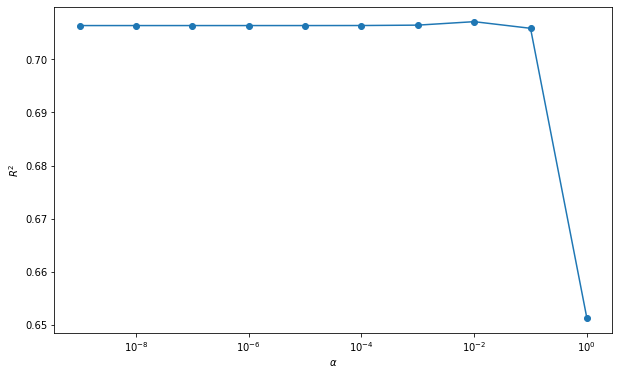

In [17]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');
plt.show()

<br><br><h2 style="color:salmon;">Exercise</h2>


    
<div style="color:#A9CCE3; font-size:1.5em">

Add <code style="background-color:#FDEBD0; color:#CD6155;">PolynomialFeatures</code> to this <code style="background-color:#FDEBD0; color:#CD6155;">Pipeline</code>, and re-run the cross validation with the <code style="background-color:#FDEBD0; color:#CD6155;">PolynomialFeatures</code> added.
    
<strong>Hint #1</strong>: pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.<br>
<strong>Hint #2</strong>: you should see a significant increase in cross validation accuracy from doing this
   
given code snippet:
    
</div>

```python
pf = PolynomialFeatures(degree=3)

scores = []
alphas = np.geomspace(0.06, 6.0, 20)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)
```
    


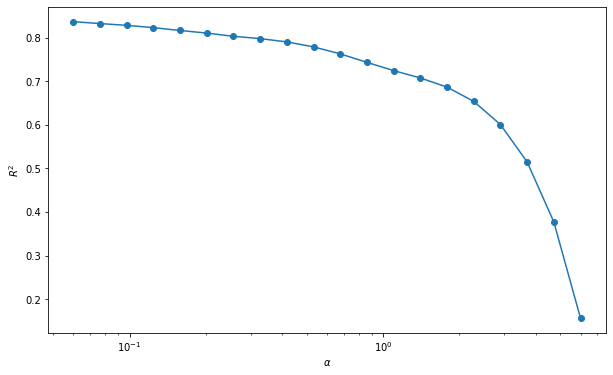

In [18]:
pf = PolynomialFeatures(degree=3)

scores_lasso = []
alphas = np.geomspace(0.06, 6.0, 20)

for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("make_higher_degree", pf),
        ("scaler", s),
        ("lasso_regression", las)
    ])

    predictions = cross_val_predict(estimator, X, y, cv=kf)
    
    score = r2_score(y, predictions)
    
    scores_lasso.append(score)
    
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores_lasso, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [19]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator_lasso = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator_lasso.fit(X, y)
best_estimator_lasso.score(X, y)

0.9134777735196521

In [20]:
best_estimator_lasso.named_steps["lasso_regression"].coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -1.00309168e+00,  3.32679107e+00, -1.01840878e+00,
       -2.56161421e+00,  1.12778302e+00, -1.72266155e+00, -5.37088506e-01,
        4.39555878e-01, -3.39542586e+00,  7.22387712e-02,  0.00000000e+00,
        0.00000000e+00,  3.53653554e+00, -0.00000000e+00,  3.72285440e-01,
        0.00000000e+00,  0.00000000e+00, -5.49528703e-01, -0.00000000e+00,
       -0.00000000e+00, -4.05522485e-02,  2.25864611e-01,  1.78508858e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.50874606e-02,
       -0.00000000e+00, -2.07295802e-01, -0.00000000e+00,  3.71781995e-01,
        0.00000000e+00, -0.00000000e+00, -5.89531100e-02,  3.47180625e-01,
        0.00000000e+00,  9.23666274e-01,  3.48873365e-01,  7.29463442e-02,
        0.00000000e+00,  0.00000000e+00,  7.68485586e-02, -7.21083596e-01,
        0.00000000e+00, -5.98542558e-01,  4.18420677e-01, -7.98165728e-01,
       -7.25062683e-01,  

<br><br><h2 style="color:salmon;">Exercise</h2>


    
<div style="color:#A9CCE3; font-size:1.5em">

Do the same, but with <code style="background-color:#FDEBD0; color:#CD6155;">Ridge</code> regression

Which model, <code style="background-color:#FDEBD0; color:#CD6155;">Ridge</code> or <code style="background-color:#FDEBD0; color:#CD6155;">Lasso</code>, performs best with its optimal hyperparameters on the Boston dataset?
    
</div>

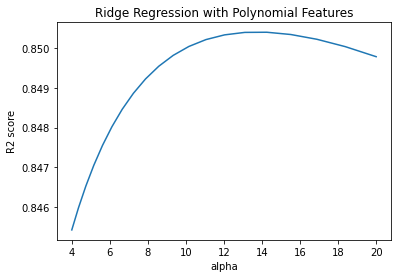

In [21]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores_ridge = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores_ridge.append(score)

plt.plot(alphas, scores_ridge)
plt.xlabel('alpha')
plt.ylabel('R2 score')
plt.title('Ridge Regression with Polynomial Features')
plt.show()


<br><br><h2 style="color:salmon;">Exercise</h2>


    
<div style="color:#A9CCE3; font-size:1.5em">

Now, for whatever your best overall hyperparameter was:

*   Standardize the data
*   Fit and predict on the entire dataset
*   See what the largest coefficients were

    → Hint:

    ```python
    dict(zip(model.coef_, pf.get_feature_names()))
    ```

    for your model `model` to get the feature names from `PolynomialFeatures`.

    Then, use

    ```python
    dict(zip(list(range(len(X.columns.values))), X.columns.values))
    ```

    to see which features in the `PolynomialFeatures` DataFrame correspond to which columns in the original DataFrame.
    
</div>

In [22]:

# Extract features and target variable
X = boston_data.drop('MEDV', axis=1)
y = boston_data.MEDV

# Standardize the data
s = StandardScaler()
X_std = s.fit_transform(X)

# Fit and predict on the entire dataset
pf = PolynomialFeatures(degree=2)
X_poly = pf.fit_transform(X_std)
lasso = Lasso(alpha=0.01, max_iter=100000)
lasso.fit(X_poly, y)
y_pred = lasso.predict(X_poly)

# Get the largest coefficients
coef_dict = dict(zip(pf.get_feature_names(), lasso.coef_))
print("Largest coefficients:")
for feature, coef in sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:10]:
    print(f"{feature}: {coef}")
    
# Map the features in the PolynomialFeatures DataFrame to the original DataFrame
original_feature_names = dict(zip(list(range(len(X.columns.values))), X.columns.values))
coef_dict_mapped = {}
for feature, coef in coef_dict.items():
    feature_num = [int(s) for s in feature if s.isdigit()][0]
    original_feature_name = original_feature_names[feature_num]
    coef_dict_mapped[original_feature_name] = coef
print()
print("Largest coefficients mapped to original features:")
for feature, coef in sorted(coef_dict_mapped.items(), key=lambda x: abs(x[1]), reverse=True)[:10]:
    print(f"{feature}: {coef}")


Largest coefficients:
x8^2: -4.991080527810556
x0 x3: 4.603071935785574
x8 x9: 4.240135996998103
x5: 3.4310177264232076
x12: -3.3062917492013835
x7: -2.8095906306308196
x2 x4: 2.3613798041858605
x6 x8: 2.025348594855447
x9 x10: 1.8804440396423487
x7 x8: -1.461145090718384

Largest coefficients mapped to original features:
RAD: -1.4313647323025422
AGE: -1.2512836094769035
TAX: -1.1151009056641341
RM: -0.9133769723234367
CRIM: 0.8848308972022697
ZN: 0.821859317290605
DIS: 0.8069487079514248
INDUS: -0.604969283887453
NOX: 0.5918337042974662
CHAS: -0.43820943823461894


   
<div style="color:#A9CCE3; font-size:1.5em">
    
<br>
    
If you want to have a dataframe az a result, let's call it `output_df`, then:

    
</div>

In [23]:
# Standardize the data
s = StandardScaler()
X_std = s.fit_transform(X)

# Fit and predict on the entire dataset
pf = PolynomialFeatures(degree=2)
X_poly = pf.fit_transform(X_std)
ridge = Ridge(alpha=10, max_iter=100000)
ridge.fit(X_poly, y)
predictions = ridge.predict(X_poly)

# Get feature names from PolynomialFeatures
poly_names = pf.get_feature_names(X.columns)

# Create a dictionary mapping polynomial features to original features
feature_map = dict(zip(list(range(len(poly_names))), poly_names))

# Get coefficients and sort them in descending order
coef_dict = dict(zip(poly_names, ridge.coef_))
sorted_coefs = sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Create output DataFrame
output_df = pd.DataFrame(columns=['Original Feature', 'Coefficient'])

# Fill output DataFrame with largest coefficients and their corresponding original features
for name, coef in sorted_coefs:
    if abs(coef) > 0:
        output_df = output_df.append({
            'Original Feature': feature_map[poly_names.index(name)],
            'Coefficient': coef
        }, ignore_index=True)
        
# Sort output DataFrame by coefficient
output_df = output_df.sort_values(by='Coefficient', key=lambda x: abs(x))


In [24]:
output_df

,Original Feature,Coefficient
103,CHAS RAD,-0.001890
102,ZN PTRATIO,0.010431
101,PTRATIO LSTAT,0.026827
100,ZN,-0.028282
99,ZN RM,0.037275
...,...,...
4,TAX PTRATIO,1.491081
3,CRIM CHAS,2.193068
2,DIS,-2.223542
1,LSTAT,-3.101785


<br><br><h2 style="color:salmon;">Grid Search CV</h2>


    
<div style="color:#A9CCE3; font-size:1.5em">

To do cross-validation, we used two techniques:

*   use `KFolds` and manually create a loop to do cross-validation
*   use `cross_val_predict` and `score` to get a cross-valiated score in a couple of lines.

To do hyper-parameter tuning, we see a general pattern:

*   use `cross_val_predict` and `score` in a manually written loop over hyperparemeters, then select the best one.

Perhaps not surprisingly, there is a function that does this for us -- `GridSearchCV`
    
</div>

In [25]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [26]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [27]:
grid.best_score_, grid.best_params_

(0.8504982950750941,
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': 15.153673507519274})

In [28]:
y_predict = grid.predict(X)

In [29]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

0.9149145594213685

In [30]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00, -1.27346408e-01, -6.16205046e-03,  2.36135244e-02,
        1.00398027e-01, -9.74110586e-01,  3.26236441e+00, -9.65057238e-01,
       -1.96344725e+00,  8.56769182e-01, -1.01488960e+00, -7.06985966e-01,
        5.52029222e-01, -3.03254502e+00,  7.74127927e-02,  7.24276605e-02,
        6.82776638e-02,  1.72849044e+00, -4.80758341e-01,  5.76219972e-01,
        1.28132069e-01,  2.22931335e-01, -7.45243542e-01,  1.66582495e-01,
       -8.00025634e-02, -8.54571642e-02,  5.07490801e-01,  2.14820391e-01,
       -1.48833274e-01,  1.42098626e-01,  1.93770221e-01,  5.02304885e-02,
       -1.12667821e-01, -2.77559685e-01, -1.32870713e-01,  7.32239658e-01,
        5.26857333e-02,  8.89966580e-02, -2.72228558e-01,  5.84383917e-01,
        1.06306947e-01,  9.62971619e-01,  5.76845132e-01,  5.33378179e-01,
        7.07913980e-01, -6.21760626e-02,  7.57641545e-02, -4.28157866e-01,
        2.40651011e-01, -6.82201736e-01,  3.40931549e-01, -9.62217889e-01,
       -8.14997204e-01,  

In [31]:
#uncomment the below to see the results:
#grid.cv_results_